In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
import desimodel.io
from bokeh.models import ColumnDataSource

In [4]:
# io.py
def read_qa(filename):
    '''
    Read QA data from qa-EXPID.fits file
    
    Returns qadata dict with keys HEADER, plus any PER_XYZ EXTNAMEs in the
    input file, and FIBERMAP if it is in the input file
    '''
    qadata = dict()
    with fitsio.FITS(filename) as fx:
        qadata['HEADER'] = fx[0].read_header()
        for hdu in fx:
            extname = hdu.get_extname()
            if extname.startswith('PER_') or extname == 'FIBERMAP':
                qadata[extname] = hdu.read()
    
    return qadata

def get_cds(data, attributes, cameras):
    '''
    Creates a column data source from DATA
    Args:
        data : a fits file of camfib data collected
        attributes : a list of metrics
        cameras : a list of cameras
    Options:
        agg : get an aggregated column data source
            to plot per fiber number instead of
            focal plane

    Returns a bokeh ColumnDataSource object
    '''
    #- Get the positions of the fibers on the focal plane
    fiberpos = Table(desimodel.io.load_fiberpos())
    fiberpos.remove_column('SPECTRO')

    #- Join the metrics data with the corresponding fibers
    #- TODO: use input fibermap instead
    data = Table(data)
    if len(data) > 0:
        data = join(data, fiberpos, keys='FIBER')

    #- bytes vs. strings
    for colname in data.colnames:
        if data[colname].dtype.kind == 'S':
            data[colname] = data[colname].astype(str)

    cds = create_cds(data, attributes)
    return cds


def create_cds(data, attributes, bin_size=25):
    '''
    Creates a column data source from DATA with metrics in ATTRIBUTES
    Args:
        data : an astropy table of camfib data collected
        attributes : a list of metrics
    '''
    data_dict = dict({})

    for colname in data.dtype.names:
        if colname in attributes:
            data_dict[colname] = data[colname].astype(np.float32)
        else:
            data_dict[colname] = data[colname]

    cds = ColumnDataSource(data=data_dict)
    return cds

In [9]:
infile = '/exposures/nightwatch/20191126/00030156/qa-00030156.fits'
qadata = read_qa(infile)

attributes = ['INTEG_RAW_FLUX', 'MEDIAN_RAW_FLUX', 'MEDIAN_RAW_SNR', 'INTEG_CALIB_FLUX',
             'MEDIAN_CALIB_FLUX', 'MEDIAN_CALIB_SNR']
cameras = ['B', 'R', 'Z']

cds = get_cds(qadata['PER_CAMFIBER'], attributes, cameras)
qadata = Table(cds.data)

# camera = 'B'
# mask = qadata['CAM']==camera
# qadata = qadata[mask]

In [6]:
tilehdu = fits.open('fiberassign-063068.fits')
tiledata = tilehdu['FIBERASSIGN'].data

In [13]:
qadata = join(tiledata, qadata, 'FIBER')

In [15]:
skymask = (qadata['CMX_TARGET'] & 2**32 > 0)
print('# sky fibers:', np.sum(skymask))

# sky fibers: 0


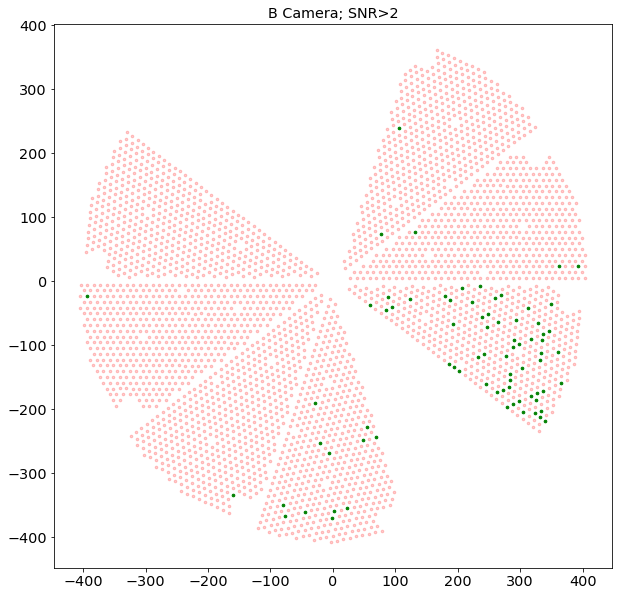

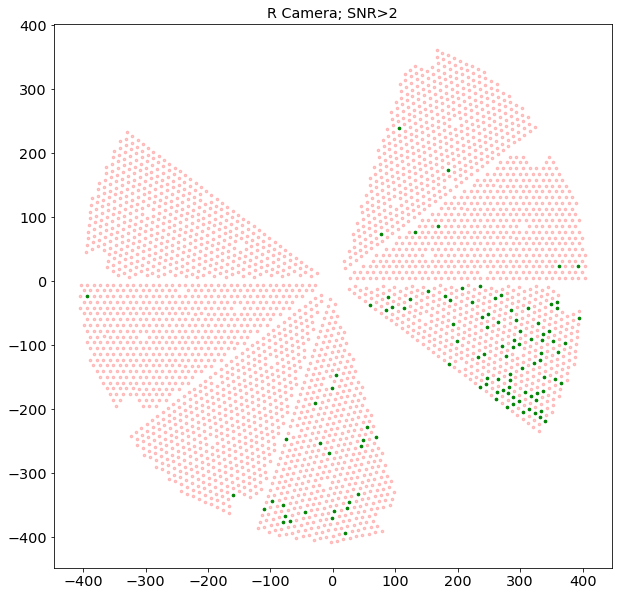

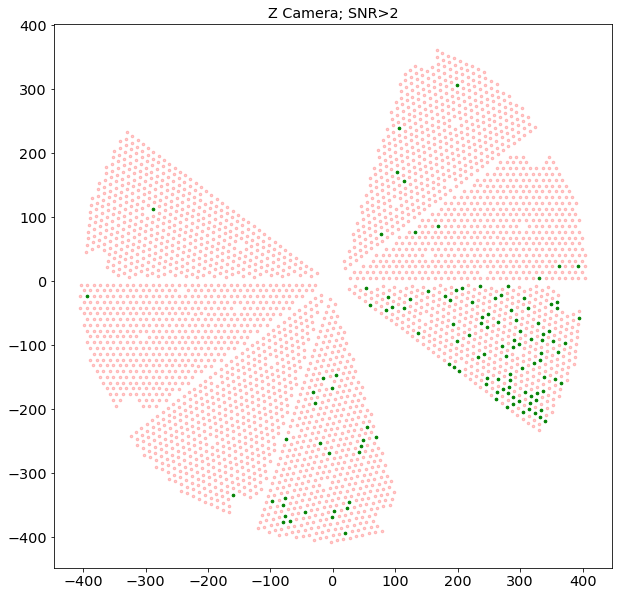

In [21]:
camera = 'Z'
snr_cut = 2

snmask = (qadata['MEDIAN_CALIB_SNR']>snr_cut)

for camera in ['B', 'R', 'Z']:
    cammask = qadata['CAM']==camera
    plt.figure(figsize=(10, 10))
    mask = cammask & snmask & (~skymask)
    plt.scatter(qadata['X'][mask], qadata['Y'][mask], s=7, c='green')
    mask = cammask & (~snmask) & (~skymask)
    plt.scatter(qadata['X'][mask], qadata['Y'][mask], s=7, c='red', alpha=0.2)
    mask = cammask & skymask
    plt.scatter(qadata['X'][mask], qadata['Y'][mask], s=7, c='cyan', alpha=1)
    # plt.colorbar()
    plt.title('{} Camera; SNR>{}'.format(camera, snr_cut))
    plt.show()